# Neural Crest Profiles

Here, we will extract the signaling pathway expression profiles for Neural Crest (Figure 6B). We will normalize the expression from this processed scRNA-seq atlas as the counts are normalized in the integrated atlas (MinMax normalized to the 95th percentile). We will then using the Nearest Neighbors algorithm to match these observed profiles to the profiles characterized from the integrated atlas (Figures 3A, 5 supplement 2A-C).

## Imports

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sb
from matplotlib import pyplot as plt

# Our modules containing the imported atlas and knn mapping functions
from python_imports import *
import knn_profiles

import warnings
warnings.simplefilter(action='ignore', category=pd.core.common.SettingWithCopyWarning)

# Set directories for the data, results, and figures.
datadir = '../../data/processed_data/kharchenko_trunk_neural_crest/'
figdir = '../figures/'

%load_ext blackcellmagic

We need to import the integrated atlas dataset and gene lists. The module `python_imports` contains the integrated atlas counts (normalized to have `1e4` counts per averaged cluster) with the metadata.

In [2]:
integrated_counts.head()

,Abi2,Acadl,Actr1b,Adam23,Adhfe1,Aff3,Als2,Ankrd39,Ankrd44,Arfgef1,...,Vldlr,Vps13a,Vti1a,Vwa2,Xpnpep1,Zdhhc16,Zdhhc6,Zfand5,Zfp518a,Zfyve27
1_E6.5_8.5_Chan,0.303576,0.221124,0.505331,0.027747,0.004190,0.062535,0.052802,0.120609,0.008379,0.154668,...,0.040407,0.087901,0.052083,0.018026,0.444120,0.315937,0.500296,0.547949,0.220705,0.063173
2_E6.5_8.5_Chan,0.126255,0.144958,0.379564,0.016781,0.011677,0.033223,0.005950,0.138309,0.000000,0.075170,...,0.004987,0.012016,0.032607,0.004283,0.383726,0.216468,0.346025,0.561872,0.085732,0.024103
3_E6.5_8.5_Chan,0.239620,0.179579,0.488773,0.066068,0.005329,0.066937,0.046102,0.152973,0.014241,0.192013,...,0.032872,0.149676,0.046820,0.036907,0.300233,0.272268,0.492421,0.565936,0.285630,0.066531
4_E6.5_8.5_Chan,0.285786,0.228204,0.506386,0.056253,0.004339,0.069220,0.049617,0.189232,0.012157,0.183135,...,0.005210,0.085233,0.034694,0.022024,0.418306,0.306199,0.501145,0.632918,0.191596,0.053865
5_E6.5_8.5_Chan,0.061935,0.196926,0.587827,0.001941,0.001248,0.008754,0.038446,0.157221,0.001325,0.238211,...,0.021238,0.075450,0.088430,0.001325,0.681848,0.310529,0.498936,0.523528,0.117121,0.060523


We can import our developmental dataset, which contains cluster-averaged counts.

In [3]:
# Neural crest profiles
trunk = pd.read_csv(datadir + "trunk_neural_crest_allgenes.csv", index_col=0)

# Separate object for the numpy matrix.
trunk_counts = trunk.iloc[:, :-3]

trunk.head()

,Sox17,Mrpl15,Lypla1,Tcea1,Rgs20,Atp6v1h,Oprk1,Rb1cc1,Fam150a,St18,...,Hccs,Mid1,G530011O06Rik,Kdm5d,Eif2s3y,Uty,Ddx3y,stage,cell_type,num_cells
0,0.000000,1.063201,1.285819,0.341201,0.007536,0.668050,0.000000,0.459874,0.000000,0.000000,...,0.599965,0.039790,0.003305,0.173730,0.242943,0.142526,0.244989,E9.5,Autonomic,152
1,0.002189,1.137547,1.411360,0.371283,0.003178,0.665362,0.000000,0.364098,0.001614,0.000000,...,0.671060,0.052159,0.006865,0.105388,0.190934,0.090720,0.183396,E9.5,Intermediate,137
10,0.000000,1.040080,1.524149,0.417662,0.002965,0.814937,0.000000,0.496417,0.000000,0.000000,...,0.711138,0.031800,0.002358,0.126702,0.248999,0.065356,0.246303,E9.5,Delamination,44
12,0.005947,1.096632,1.634716,0.391246,0.000000,0.901613,0.013146,0.468439,0.000000,0.049165,...,0.550289,0.088373,0.005674,0.025519,0.078991,0.149104,0.205125,E9.5,Sensory,25
3,0.000000,0.911934,1.235161,0.315175,0.006159,0.653469,0.007570,0.368842,0.000000,0.000258,...,0.517046,0.138100,0.008087,0.129759,0.213461,0.125647,0.172651,E9.5,Premigratory,125


We will normalize the developmental datasets in a similar manner to the integrated atlas dataset. Specifically, we will preserve only genes that are in the integrated atlas, and set any genes absent from the developmental dataset to have zero counts. We will then set the total counts for each cluster to be `1e4` as well. 

In [4]:
# Get the intersection of genes between the two datasets
trunk_counts = trunk_counts[
    list(set(trunk.columns).intersection(set(integrated_counts.columns)))
]

# Normalize the neural crest counts to have 1e4 total
trunk_norm = np.log1p(trunk_counts.div(trunk_counts.sum(axis=1), axis=0) * 1e4)

# If there are genes in the integrated atlas dataset that are not in the neural crest dataset we just set them to 0
missing_genes = list(
    set(integrated_counts.columns).difference(set(trunk_counts.columns))
)
trunk_norm[missing_genes] = np.zeros((len(trunk_norm), len(missing_genes)))

np.expm1(trunk_norm).sum(axis=1)

# Add cell type annotation
trunk_norm["cell_type"] = trunk["cell_type"]

trunk_norm.head()

,Cdc123,Gdf15,Itpkb,Nfkbid,Wipf2,Nudt5,Stk32b,Zyx,Il18,Nup50,...,Lgals7,Bmp15,C3,Rasgrp1,Cdcp1,Lrrc2,Ass1,Ambp,Calb1,cell_type
0,1.498300,0.002345,0.027149,0.015263,0.305991,1.091992,0.010210,0.765721,0.053643,1.061516,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Autonomic
1,1.465292,0.001446,0.007483,0.013153,0.327635,1.162565,0.027321,0.830426,0.013499,1.086796,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Intermediate
10,1.496583,0.000000,0.003499,0.018937,0.216005,1.206587,0.053410,1.099608,0.020288,1.102037,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Delamination
12,1.523289,0.000000,0.000000,0.058696,0.285273,1.137666,0.000000,0.608212,0.034340,1.080213,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Sensory
3,1.473593,0.000722,0.007841,0.050053,0.354354,1.064395,0.035452,0.893876,0.051464,1.076738,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Premigratory


We can plot the normalized cluster counts in the order in which the clusters appear in in pseudotime, which in `Figure_6A.ipynb`, was determined to be `[9, 3, 10, 5, 8, 1, 12]`.

In [5]:
# Ordering of clusters
order_clust = [9, 3, 10, 5, 8, 1, 12]

## Scaling Data and Obtaining Cluster Matches with KNN

Here, we seek to match the developmental clusters to the profiles we obtained from the more comprehensive integrated atlas dataset. For each gene set, we will scale the developmental data to be MinMax-scaled between `[0,1]` using the quantiles computed from the integrated atlas dataset. Then, used this MinMax-scaled develpmental data we will using the K-nearest neighbors algorithm to find the profiles in the integrated atlas to which they most closely correspond. We define "profiles" in the integrated atlas to be the averaged MinMax-scaled counts for all clusters that belong to a profile.

The `knn_profiles.knn_mapping` function performs all these steps. We input the developmental data as `raw_data`, the integrated atlas data, pathway gene list, and the criteria we use for determining whether a pathway is "ON" in a cluster (`min_expr` and `min_genes_on`).

Below, we conduct this analysis for the TGF-β receptors, Notch, Eph-Ephrin, and Wnt receptor signaling components. We output the normalized data as `df_norm` and in a heatmap, and the top nearest profiles as `df_top` as a table.

,unique
0,"[6, 29, 15]"
1,"[29, 15, 6]"
2,"[6, 3, 5]"
3,"[6, 3, 13]"
4,"[6, 3, 13]"
5,"[6, 3, 5]"
6,"[6, 5, 3]"


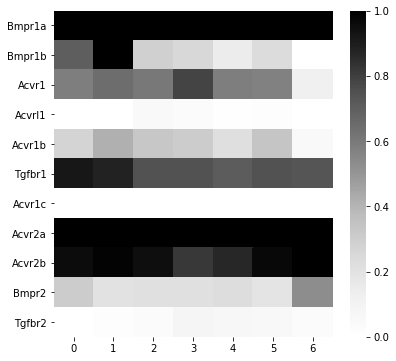

In [6]:
pathway_name = "tgfb"
pathway_genes = tgfb
min_expr = 0.2
min_genes_on = 2

raw_data = trunk_norm
prof_anno = pd.read_csv(
    "../../scripts/analysis/outputs/" + pathway_name + "_analysis/" + pathway_name + "_profiles.csv", index_col=1
)

# Get the normalized count matrix, and the top nearest neighbors from the integrated dataset to each leiden cluster.
df_norm, df_top = knn_profiles.knn_mapping(
    raw_data,
    prof_anno=prof_anno,
    integrated_counts=integrated_counts,
    pathway_genes=pathway_genes,
    pathway_name=pathway_name,
    min_expr=min_expr,
    min_genes_on=min_genes_on,
    n_nearest=3,
)

# Make a plot of the normalized counts
fig, ax = plt.subplots(figsize=(5 * 10 / 8, 6))
df_norm = df_norm.loc[order_clust]
df_norm.index = ["0", "1", "2", "3", "4", "5", "6"]
sb.heatmap(df_norm.T, cmap="Greys", ax=ax)

# Display the top nearest neighbors
df_top.index = df_top["class_label"]
df_top.groupby("leiden")["class_label"].agg(["unique"]).loc[order_clust].reset_index()[
    ["unique"]
]

,unique
0,"[16, 6, 18]"
1,"[16, 18, 20]"
2,"[16, 18, 6]"
3,"[16, 25, 20]"
4,"[16, 2, 6]"
5,"[16, 25, 20]"
6,"[27, 17, 1]"


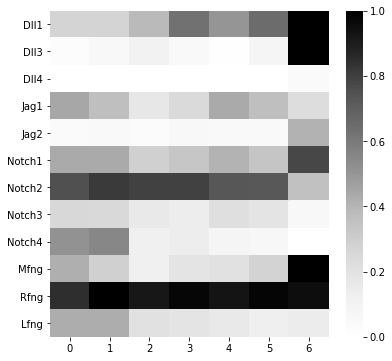

In [7]:
pathway_name = "notch"
pathway_genes = notch
min_expr = 0.2
min_genes_on = 2

raw_data = trunk_norm
prof_anno = pd.read_csv(
    "../../scripts/analysis/outputs/" + pathway_name + "_analysis/" + pathway_name + "_profiles.csv", index_col=1
)

# Get the normalized count matrix, and the top nearest neighbors from the integrated dataset to each leiden cluster.
df_norm, df_top = knn_profiles.knn_mapping(
    raw_data,
    prof_anno=prof_anno,
    integrated_counts=integrated_counts,
    pathway_genes=pathway_genes,
    pathway_name=pathway_name,
    min_expr=min_expr,
    min_genes_on=min_genes_on,
    n_nearest=3,
)

# Make a plot of the normalized counts
fig, ax = plt.subplots(figsize=(5 * 10 / 8, 6))
df_norm = df_norm.loc[order_clust]
df_norm.index = ["0", "1", "2", "3", "4", "5", "6"]
sb.heatmap(df_norm.T, cmap="Greys", ax=ax)

# Display the top nearest neighbors
df_top.index = df_top["class_label"]
df_top.groupby("leiden")["class_label"].agg(["unique"]).loc[order_clust].reset_index()[
    ["unique"]
]

,unique
0,"[19.0, 48.0, 29.0]"
1,"[13.0, 19.0, 48.0]"
2,"[19.0, 11.0, 13.0]"
3,"[13.0, 11.0, 16.0]"
4,"[19.0, 29.0, 11.0]"
5,"[11.0, 29.0, 12.0]"
6,"[16.0, 11.0, 29.0]"


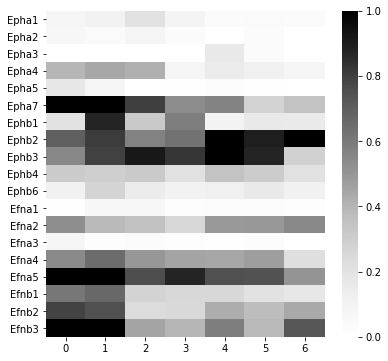

In [8]:
pathway_name = "eph-ephrin"
pathway_genes = eph_ephrin
min_expr = 0.2
min_genes_on = 2

raw_data = trunk_norm
prof_anno = pd.read_csv(
    "../../scripts/analysis/outputs/" + pathway_name + "_analysis/" + pathway_name + "_profiles.csv", index_col=1
)

# Get the normalized count matrix, and the top nearest neighbors from the integrated dataset to each leiden cluster.
df_norm, df_top = knn_profiles.knn_mapping(
    raw_data,
    prof_anno=prof_anno,
    integrated_counts=integrated_counts,
    pathway_genes=pathway_genes,
    pathway_name=pathway_name,
    min_expr=min_expr,
    min_genes_on=min_genes_on,
    n_nearest=3,
)

# Make a plot of the normalized counts
fig, ax = plt.subplots(figsize=(5 * 10 / 8, 6))
df_norm = df_norm.loc[order_clust]
df_norm.index = ["0", "1", "2", "3", "4", "5", "6"]
sb.heatmap(df_norm.T, cmap="Greys", ax=ax)

# Display the top nearest neighbors
df_top.index = df_top["class_label"]
df_top.groupby("leiden")["class_label"].agg(["unique"]).loc[order_clust].reset_index()[
    ["unique"]
]

,unique
0,"[11.0, 29.0, 8.0]"
1,"[11.0, 8.0, 10.0]"
2,"[8.0, 9.0, 11.0]"
3,"[10.0, 8.0, 11.0]"
4,"[10.0, 1.0, 9.0]"
5,"[10.0, 1.0, 9.0]"
6,"[10.0, 1.0, 30.0]"


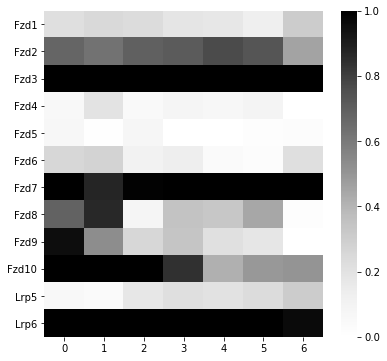

In [9]:
pathway_name = "wnt"
pathway_genes = wntr
min_expr = 0.2
min_genes_on = 2

raw_data = trunk_norm
prof_anno = pd.read_csv(
    "../../scripts/analysis/outputs/" + pathway_name + "_analysis/" + pathway_name + "_profiles.csv", index_col=1
)

# Get the normalized count matrix, and the top nearest neighbors from the integrated dataset to each leiden cluster.
df_norm, df_top = knn_profiles.knn_mapping(
    raw_data,
    prof_anno=prof_anno,
    integrated_counts=integrated_counts,
    pathway_genes=pathway_genes,
    pathway_name=pathway_name,
    min_expr=min_expr,
    min_genes_on=min_genes_on,
    n_nearest=3,
)

# Make a plot of the normalized counts
fig, ax = plt.subplots(figsize=(5 * 10 / 8, 6))
df_norm = df_norm.loc[order_clust]
df_norm.index = ["0", "1", "2", "3", "4", "5", "6"]
sb.heatmap(df_norm.T, cmap="Greys", ax=ax)

# Display the top nearest neighbors
df_top.index = df_top["class_label"]
df_top.groupby("leiden")["class_label"].agg(["unique"]).loc[order_clust].reset_index()[
    ["unique"]
]

In [10]:
%load_ext watermark
%watermark -v -p numpy,pandas,scipy,seaborn,matplotlib,anndata,scanpy,jupyterlab

Python implementation: CPython
Python version       : 3.8.5
IPython version      : 7.17.0

numpy     : 1.18.5
pandas    : 1.1.0
scipy     : 1.5.2
seaborn   : 0.10.1
matplotlib: 3.2.2
anndata   : 0.7.4
scanpy    : 1.5.1
jupyterlab: 2.2.4

